# Question 2.5: GAN Distances

Initialize libraries

In [1]:
import math
import random
import os


from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Helper stuff

#### Insert other helpers

In [0]:
# ==
# From sampler


def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 2.3
    # USAGE:
    #     sampler = iter(samplers.distribution1(0))
    #     data = next(sampler)
    while True:
        yield(np.array([(x, random.uniform(0, 1), ) for _ in range(batch_size)]))



# ==
# From model



class Critic(nn.Module):
    # DONT MODIFY. Use this module for every questions of Q1. Your tests might fail if you modify this.
    def __init__(self, in_size=2):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_size, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, input):
        output = self.main(input)
        return output.squeeze()
        

#### Insert **Distance Functions**

In [0]:
def lp_reg(x, y, critic):
    """
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** The notation used for the parameters follow the one from Petzka et al: https://arxiv.org/pdf/1709.08894.pdf
    In other word, x are samples from the distribution mu and y are samples from the distribution nu. The critic is the
    equivalent of f in the paper. Also consider that the norm used is the L2 norm. This is important to consider,
    because we make the assumption that your implementation follows this notation when testing your function. ***

    :param x: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution P.
    :param y: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution Q.
    :param critic: (Module) - torch module that you want to regularize.
    :return: (FloatTensor) - shape: (1,) - Lipschitz penalty
    """

    # ==
    # Lipschitz penalty

    # Compute sample to use
    unif = torch.distributions.uniform.Uniform(0.0, 1.0)
    u = unif.sample()
    x_hat = (u * x) + ((1-u) * y)
    x_hat = x_hat.clone().detach().requires_grad_(True)

    # Compute gradient of sample
    f_x = critic(x_hat)
    f_x_sum = torch.sum(f_x)
    f_x_sum.backward()

    # Gradient norm of x.grad, x.grad has shape (batch, feature)
    dx_norm = torch.norm(x_hat.grad, p=2, dim=1,
                         keepdim=False)  # (batch, )

    # Compute the per-element gradient penalty
    #zeros = torch.zeros(dx_norm.size()).to(x_hat.device)
    #grad_penalty = torch.max(zeros, (dx_norm - 1.0))  # (batch, )

    # TODO: try the relu in the unit test and in training
    grad_penalty = torch.nn.functional.relu((dx_norm - 1.0))
    grad_penalty_sq = grad_penalty.pow(2)

    # Compute Lipschitz penalty
    lp = torch.mean(grad_penalty_sq)

    return lp


def vf_wasserstein_distance(x, y, critic):
    """
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** The notation used for the parameters follow the one from Petzka et al: https://arxiv.org/pdf/1709.08894.pdf
    In other word, x are samples from the distribution mu and y are samples from the distribution nu. The critic is the
    equivalent of f in the paper. This is important to consider, because we make the assuption that your implementation
    follows this notation when testing your function. ***

    :param p: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution p.
    :param q: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution q.
    :param critic: (Module) - torch module used to compute the Wasserstein distance
    :return: (FloatTensor) - shape: (1,) - Estimate of the Wasserstein distance
    """

    # ==
    # Wasserstein distance

    f_P = critic(x)  # real samples, (batch, )
    f_Q = critic(y)  # generated samples, (batch, )

    # Estimate empirical Wasserstein distance
    wd = torch.mean(f_P) - torch.mean(f_Q)

    return wd


def vf_squared_hellinger(x, y, critic):
    """
    Complete me. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** The notation used for the parameters follow the one from Nowazin et al: https://arxiv.org/pdf/1606.00709.pdf
    In other word, x are samples from the distribution P and y are samples from the distribution Q. Please note that the Critic is unbounded. ***

    :param p: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution p.
    :param q: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution q.
    :param critic: (Module) - torch module used to compute the Squared Hellinger.
    :return: (FloatTensor) - shape: (1,) - Estimate of the Squared Hellinger
    """

    # ==
    # Squared Hellinger objective

    # Compute V(x)'s
    v_P = critic(x)  # (batch, )
    v_Q = critic(y)  # (batch, )

    # Compute g(v)
    gv_P = 1.0 - (-v_P).exp()  # (batch, )
    gv_Q = 1.0 - (-v_Q).exp()  # (batch, )

    # Compute -f(g)
    neg_f = - ((gv_Q) / (1.0 - gv_Q))  # (batch, )

    # Empirical average Squared Hellinger loss
    sq = torch.mean((gv_P + neg_f))

    return sq

### Initialize stuff

Model and first distribution (P)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Regularizaiton constant
lambda_reg_lp = 50  # Recommended hyper parameters for the lipschitz regularizer.

cuda


### Training

#### Helper function

In [0]:
def train_critic(critic, critic_optim, theta, dist_fn, 
                 n_batches=100, print_freq=10, device='cpu'):
  # == 
  # Initialize sampler

  # Samplers
  p_sampler = iter(distribution1(0, batch_size=512))
  q_sampler = iter(distribution1(theta, batch_size=512))

  # ==
  # Train
  for batch_idx in range(n_batches):
    # Get data
    P_X = next(p_sampler)
    Q_Y = next(q_sampler)
    P_tensor = torch.tensor(P_X, dtype=torch.float).to(device)
    Q_tensor = torch.tensor(Q_Y, dtype=torch.float).to(device)
    
    # Train
    critic.zero_grad()
    dist_measure = dist_fn(P_tensor, Q_tensor, critic)
    lip_penalty = lp_reg(P_tensor, Q_tensor, critic)

    # Compute loss
    loss = (-dist_measure) + (lambda_reg_lp * lip_penalty)

    loss.backward()
    critic_optim.step()

    if (batch_idx+1) % print_freq == 0:
      print(f'\tCritic loss: {loss.item()}')
  
  return dist_measure.item()

#### Evaluate distance

In [9]:
theta_list = []
sqhel_list = []
wassd_list = []

for theta in np.arange(0, 2.01, 0.1):

  # ==
  # Training parameters
  n_batches = 200
  print_freq = 100
  

  # ==
  # Squared Hellinger distance

  # Initialize model
  model = Critic(2).to(device)
  optim = torch.optim.SGD(model.parameters(), lr=1e-6)
  # Train model
  print(f'Squared Hellinge, theta={theta}')
  fin_sh_dist = train_critic(model, optim, theta, vf_squared_hellinger, 
                             n_batches=n_batches, print_freq=print_freq, 
                             device=device)
  
  
  # ==
  # Wasserstein distance

  # Initialize model
  model = Critic(2).to(device)
  optim = torch.optim.SGD(model.parameters(), lr=1e-6)

  # Train model
  print(f'Wasserstein, theta={theta}')
  fin_ws_dist = train_critic(model, optim, theta, vf_wasserstein_distance, 
                             n_batches=n_batches, print_freq=print_freq, 
                             device=device)
  
  
  # Save
  theta_list.append(theta)
  sqhel_list.append(fin_sh_dist)
  wassd_list.append(fin_ws_dist)


Squared Hellinge, theta=0.0
	Critic loss: 0.031627628952264786
	Critic loss: 0.16586941480636597
Wasserstein, theta=0.0
	Critic loss: 0.0010042041540145874
	Critic loss: -0.0008223950862884521
Squared Hellinge, theta=0.1
	Critic loss: 0.08043816685676575
	Critic loss: 0.3078439235687256
Wasserstein, theta=0.1
	Critic loss: -0.0015581697225570679
	Critic loss: -0.002563178539276123
Squared Hellinge, theta=0.2
	Critic loss: 0.033209435641765594
	Critic loss: 0.1482733190059662
Wasserstein, theta=0.2
	Critic loss: 0.009482592344284058
	Critic loss: 0.009566813707351685
Squared Hellinge, theta=0.30000000000000004
	Critic loss: 0.040261588990688324
	Critic loss: 0.14358098804950714
Wasserstein, theta=0.30000000000000004
	Critic loss: -0.01151902973651886
	Critic loss: -0.0159166157245636
Squared Hellinge, theta=0.4
	Critic loss: 0.0177262295037508
	Critic loss: 0.08433898538351059
Wasserstein, theta=0.4
	Critic loss: -0.0029735565185546875
	Critic loss: -0.013879179954528809
Squared Helling

### Visualize

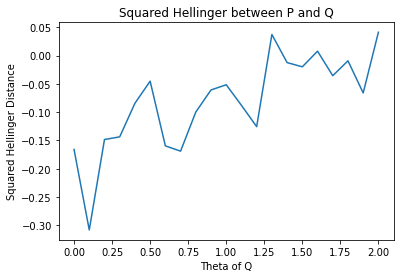

In [10]:
sns.lineplot(x=theta_list, y=sqhel_list)
plt.title('Squared Hellinger between P and Q')
plt.xlabel('Theta of Q')
plt.ylabel('Squared Hellinger Distance')
#plt.ylim([-0.055, 0.0])
plt.show()

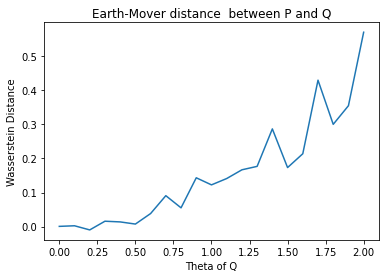

In [11]:
sns.lineplot(x=theta_list, y=wassd_list)
plt.title('Earth-Mover distance  between P and Q')
plt.xlabel('Theta of Q')
plt.ylabel('Wasserstein Distance')
#plt.ylim([-0.055, 0.003])
plt.show()